<a href="https://colab.research.google.com/github/TensorFlowing/Deep-Learning-Experiments/blob/master/super_resolution_with_onnxruntime_tested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


(optional) Exporting a Model from PyTorch to ONNX and Running it using ONNX Runtime
========================================================================

In this tutorial, we describe how to convert a model defined
in PyTorch into the ONNX format and then run it with ONNX Runtime.

ONNX Runtime is a performance-focused engine for ONNX models,
which inferences efficiently across multiple platforms and hardware
(Windows, Linux, and Mac and on both CPUs and GPUs).
ONNX Runtime has proved to considerably increase performance over
multiple models as explained `here
<https://cloudblogs.microsoft.com/opensource/2019/05/22/onnx-runtime-machine-learning-inferencing-0-4-release>`__

For this tutorial, you will need to install `ONNX <https://github.com/onnx/onnx>`__
and `ONNX Runtime <https://github.com/microsoft/onnxruntime>`__.
You can get binary builds of ONNX and ONNX Runtime with
``pip install onnx onnxruntime``.
Note that ONNX Runtime is compatible with Python versions 3.5 to 3.7.

``NOTE``: This tutorial needs PyTorch master branch which can be installed by following
the instructions `here <https://github.com/pytorch/pytorch#from-source>`__




In [ ]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

Super-resolution is a way of increasing the resolution of images, videos
and is widely used in image processing or video editing. For this
tutorial, we will use a small super-resolution model.

First, let's create a SuperResolution model in PyTorch.
This model uses the efficient sub-pixel convolution layer described in
`"Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network" - Shi et al <https://arxiv.org/abs/1609.05158>`__
for increasing the resolution of an image by an upscale factor.
The model expects the Y component of the YCbCr of an image as an input, and
outputs the upscaled Y component in super resolution.

`The
model <https://github.com/pytorch/examples/blob/master/super_resolution/model.py>`__
comes directly from PyTorch's examples without modification:




In [ ]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init

class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

Ordinarily, you would now train this model; however, for this tutorial,
we will instead download some pre-trained weights. Note that this model
was not trained fully for good accuracy and is used here for
demonstration purposes only.

It is important to call ``torch_model.eval()`` or ``torch_model.train(False)``
before exporting the model, to turn the model to inference mode.
This is required since operators like dropout or batchnorm behave
differently in inference and training mode.




In [ ]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

Downloading: "https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth" to /root/.cache/torch/hub/checkpoints/superres_epoch100-44c6958e.pth


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

Exporting a model in PyTorch works via tracing or scripting. This
tutorial will use as an example a model exported by tracing.
To export a model, we call the ``torch.onnx.export()`` function.
This will execute the model, recording a trace of what operators
are used to compute the outputs.
Because ``export`` runs the model, we need to provide an input
tensor ``x``. The values in this can be random as long as it is the
right type and size.
Note that the input size will be fixed in the exported ONNX graph for
all the input's dimensions, unless specified as a dynamic axes.
In this example we export the model with an input of batch_size 1,
but then specify the first dimension as dynamic in the ``dynamic_axes``
parameter in ``torch.onnx.export()``.
The exported model will thus accept inputs of size [batch_size, 1, 224, 224]
where batch_size can be variable.

To learn more details about PyTorch's export interface, check out the
`torch.onnx documentation <https://pytorch.org/docs/master/onnx.html>`__.




In [ ]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
# converting a torch model to a onnx model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

We also computed ``torch_out``, the output after of the model,
which we will use to verify that the model we exported computes
the same values when run in ONNX Runtime.

But before verifying the model's output with ONNX Runtime, we will check
the ONNX model with ONNX's API.
First, ``onnx.load("super_resolution.onnx")`` will load the saved model and
will output a onnx.ModelProto structure (a top-level file/container format for bundling a ML model.
For more information `onnx.proto documentation <https://github.com/onnx/onnx/blob/master/onnx/onnx.proto>`__.).
Then, ``onnx.checker.check_model(onnx_model)`` will verify the model's structure
and confirm that the model has a valid schema.
The validity of the ONNX graph is verified by checking the model's
version, the graph's structure, as well as the nodes and their inputs
and outputs.




In [ ]:
!pip install onnx

     |████████████████████████████████| 7.7MB 6.5MB/s 


In [ ]:

import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

Now let's compute the output using ONNX Runtime's Python APIs.
This part can normally be done in a separate process or on another
machine, but we will continue in the same process so that we can
verify that ONNX Runtime and PyTorch are computing the same value
for the network.

In order to run the model with ONNX Runtime, we need to create an
inference session for the model with the chosen configuration
parameters (here we use the default config).
Once the session is created, we evaluate the model using the run() api.
The output of this call is a list containing the outputs of the model
computed by ONNX Runtime.




In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 3.8MB 8.1MB/s 


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


We should see that the output of PyTorch and ONNX Runtime runs match
numerically with the given precision (rtol=1e-03 and atol=1e-05).
As a side-note, if they do not match then there is an issue in the
ONNX exporter, so please contact us in that case.




Running the model on an image using ONNX Runtime
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




So far we have exported a model from PyTorch and shown how to load it
and run it in ONNX Runtime with a dummy tensor as an input.



For this tutorial, we will use a famous cat image used widely which
looks like below

.. figure:: /_static/img/cat_224x224.jpg
   :alt: cat




First, let's load the image, pre-process it using standard PIL
python library. Note that this preprocessing is the standard practice of
processing data for training/testing neural networks.

We first resize the image to fit the size of the model's input (224x224).
Then we split the image into its Y, Cb, and Cr components.
These components represent a greyscale image (Y), and
the blue-difference (Cb) and red-difference (Cr) chroma components.
The Y component being more sensitive to the human eye, we are
interested in this component which we will be transforming.
After extracting the Y component, we convert it to a tensor which
will be the input of our model.




In [ ]:
!wget https://pytorch.org/tutorials/_images/cat_224x224.jpg

--2020-12-10 17:40:59--  https://pytorch.org/tutorials/_images/cat_224x224.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10270 (10K) [image/jpeg]
Saving to: ‘cat_224x224.jpg’

cat_224x224.jpg     100%[===================>]  10.03K  --.-KB/s    in 0s      

2020-12-10 17:41:00 (47.7 MB/s) - ‘cat_224x224.jpg’ saved [10270/10270]



In [ ]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("./cat_224x224.jpg")

resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)
print(img_y.shape)

torch.Size([1, 1, 224, 224])


Now, as a next step, let's take the tensor representing the
greyscale resized cat image and run the super-resolution model in
ONNX Runtime as explained previously.




In [ ]:
# key: running the inference engine
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)} # build a dict of input nodes?
ort_outs = ort_session.run(None, ort_inputs) # first argument is the input option?
img_out_y = ort_outs[0]

At this point, the output of the model is a tensor.
Now, we'll process the output of the model to construct back the
final output image from the output tensor, and save the image.
The post-processing steps have been adopted from PyTorch
implementation of super-resolution model
`here <https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py>`__.




In [ ]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

# Save the image, we will compare this with the output image from mobile device
final_img.save("./cat_superres_with_ort.jpg")


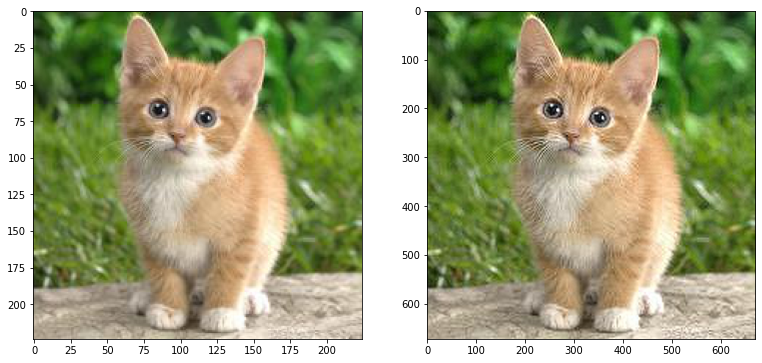

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(20,20)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(final_img)
plt.show()

.. figure:: /_static/img/cat_superres_with_ort.jpg
   :alt: output\_cat


ONNX Runtime being a cross platform engine, you can run it across
multiple platforms and on both CPUs and GPUs.

ONNX Runtime can also be deployed to the cloud for model inferencing
using Azure Machine Learning Services. More information `here <https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-onnx>`__.

More information about ONNX Runtime's performance `here <https://github.com/microsoft/onnxruntime#high-performance>`__.


For more information about ONNX Runtime `here <https://github.com/microsoft/onnxruntime>`__.


